# Resource Utilization

RADICAL-Analytics (RA) allows to calculate resource utilization for single and multiple RADICAL-Pilot (RP) sessions. Currently, RA supports CPU and GPU resources but in the future may support also RAM and I/O.

Resource utilization is expressed as the amount of time for which each task and pilot utilized available resources. For example, ``task_000000`` may have used 6 GPUs and 1 core for 15 minutes, and ``pilot_0000`` may have utilized (better, held) all the available resources for 1 hour.

RA can further characterize resource utilization by differentiating among the state in which each task and pilot were when utilizing (or holding) available resources. For example, ``pilot_0000`` may have held all the available resources for 5 minutes while bootstrapping or a variable amount of resources while scheduling each task. Similarly, tasks may held resources while being in a pre_execution or cmd_execution state.

Calculating resource utilization for all the entities and all their states is computationally expensive: given a 2020 laptop with 8 cores and 32GB of RAM, RA takes ~4 hours to plot the resource utilization of 100,000 heterogeneous tasks executed on a pilot with 200,000 CPUs and 24,000 GPUs. For sessions with 1M+ tasks, RA cannot be utilized to plot completed resource utilization in a reasonable amount of time.

Thus, RA offers two ways to compute resource utilization: fully detailed and aggregated. In the former, RA calculates the utilization for each core (e.g., core and GPU); in the latter, RA calculates the aggregated utilization of the resources over time, without mapping utilization over resource IDs. Aggregated utilization is less computationally intensive and it has been used to plot runs with 10M+ tasks.

## Prologue

Load the Python modules needed to profile and plot a RP session.

In [2]:
import os
import tarfile

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import radical.utils as ru
import radical.pilot as rp
import radical.entk as re
import radical.analytics as ra

Load the RADICAL Matplotlib style to obtain viasually consistent and publishable-qality plots.

In [ ]:
plt.style.use(ra.get_mplstyle('radical_mpl'))

Usually, it is useful to record the stack used for the analysis. 

<div class="alert alert-info">

__Note:__ The analysis stack might be different from the stack used to create the session to analyze. Usually, the two stacks must have the same minor release number (Major.Minor.Patch) in order to be compatible.

</div>

In [3]:
! radical-stack

1664961174.327 : radical.analytics    : 29414 : 139910510348096 : INFO     : radical.analytics    version: 1.16.0-v1.16.0-24-g1ea17a5@fix-rtd_build

  python               : /mnt/home/merzky/radical/radical.analytics.devel/ve3/bin/python3
  pythonpath           : 
  version              : 3.8.0
  virtualenv           : /mnt/home/merzky/radical/radical.analytics.devel/ve3

  radical.analytics    : 1.16.0-v1.16.0-24-g1ea17a5@fix-rtd_build
  radical.entk         : 1.16.0-v1.16.0@master
  radical.gtod         : 1.13.0
  radical.pilot        : 1.17.0-v1.17.0-148-g5a63a7f8e@devel
  radical.saga         : 1.17.0-v1.17.0-2-g5b9803bb@devel
  radical.utils        : 1.17.0-v1.17.0-4-ge3c8acb@fix-docs



## Detailed Resource Utilization

Given a RP session, RA helper functions take one resource type as input and return utilization, patches and legends for that type of resource. Plotting multiple types of resources requires creating separate plots. If needed, plots can be stacked, maintaining their time alignment. Here the default workflow to create a detailed utilization plot, with stacked plots for CPU and GPU resources.

### Metrics

Define the metrics you want RA to use to calculate resource utilization of task(s) and pilot(s). A metric is used to measure the amount of time for which a set of resource was used by an entity in a specific state. The list of all available durations is in ``rp.utils.PILOT_DURATIONS``; ``rp.utils.TASK_DURATIONS_DEFAULT``; ``rp.utils.TASK_DURATIONS_APP``; ``rp.utils.TASK_DURATIONS_PRTE``; and ``rp.utils.ASK_DURATIONS_PRTE_APP``. Each metric has a label---the name of the metric---, a list of durations, and a color used when plotting that metric.

One can use an arbitrary number of metrics, depending on the information that the plot needs to convey. For example, using only 'Exec Cmd' will show the time for which each resource was utilized to execute a given task. The rest of the plot will be white, indicating that the resources where otherwise utilized or idling.

Barring exceptional cases, colors should not be changed when using RA for RADICAL publications.

In [4]:
    metrics = [
        ['Bootstrap', ['boot', 'setup_1']                         , '#c6dbef'],
        ['Warmup'   , ['warm' ]                                   , '#f0f0f0'],
        ['Schedule' , ['exec_queue','exec_prep', 'unschedule']    , '#c994c7'],
        ['Exec RP'  , ['exec_rp', 'exec_sh', 'term_sh', 'term_rp'], '#fdbb84'],
        ['Exec Cmd' , ['exec_cmd']                                , '#e31a1c'],
        ['Cooldown' , ['drain']                                   , '#addd8e']
    ]

### Sessions

Name a location of all the sessions of the experiment. 

In [5]:
sids = ['rp.session.rivendell.merzky.019270.0000',
        'rp.session.rivendell.merzky.019270.0001',
        'rp.session.rivendell.merzky.019270.0002',
        'rp.session.rivendell.merzky.019270.0003']
sdir = 'sessions/'
sessions = [sdir + s for s in sids]

Unbzip and untar those sessions.

In [6]:
for sid in sids:
    sp = sdir + sid + '.tar.bz2'
    tar = tarfile.open(sp, mode='r:bz2')
    tar.extractall(path=sdir)
    tar.close()

Create a ``ra.Session`` object for the session. We do not need EnTK-specific traces so load only the RP traces contained in the EnTK session. Thus, we pass the ``'radical.pilot'`` session type to ``ra.Session``.

<div class="alert alert-warning">
    
__Warning:__ We already know we need information about pilots and tasks. Thus, we save in memory two session objects filtered for pilots and tasks. This might be too expensive with large sessions, depending on the amount of memory available.

</div>
    
<div class="alert alert-info">
    
__Note:__ We save the ouput of ``ra.Session`` in ``capt`` to avoid polluting the notebook with warning messages. 

</div>

In [7]:
%%capture capt

ss = {}
for sid in sids:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot', inplace=False),
                    't': ss[sid]['s'].filter(etype='task' , inplace=False)})

Derive the information about each session we need to use in our plots.

In [8]:
for sid in sids:
    
    ss[sid].update({'cores_node': ss[sid]['s'].get(etype='pilot')[0].cfg['resource_details']['rm_info']['cores_per_node'],
                    'pid'       : ss[sid]['p'].list('uid'),
                    'ntask'     : len(ss[sid]['t'].get())
    })
    
    ss[sid].update({'ncores'    : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus'     : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']
    })
    
    ss[sid].update({'nnodes'    : int(ss[sid]['ncores']/ss[sid]['cores_node'])})

### Experiment

Construct a ``ra.Experiment`` object and calculate the starting point of each pilot in order to zero the X axis of the plot. Without that, the plot would start after the time spent by the pilot waiting in the queue. The experiment object exposes a method to calculate the consumption of each resource for each entity and metric.

In [9]:
%%capture capt

exp = ra.Experiment(sessions, stype='radical.pilot')

Use ``ra.Experiment.utilization()`` to profile GPU resources utilization. Use the metrics defined above and all the sessions of the experiment ``exp``.

In [10]:
# Type of resource we want to plot: cpu or gpu
rtypes=['cpu', 'gpu']

provided, consumed, stats_abs, stats_rel, info = exp.utilization(metrics=metrics, rtype=rtypes[1])

### Plotting GPU Utilization

We now have everything we need to plot the detailed GPU utilization of the experiment with Matplotlib.

Text(0.5, -0.2, 'Time (s)')

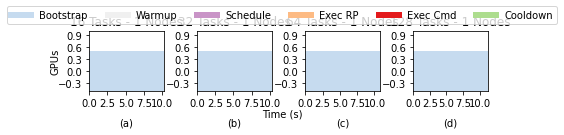

In [11]:
# sessions you want to plot
splot = [os.path.basename(s) for s in sessions]
nsids = len(splot)

# Get the start time of each pilot
p_zeros = ra.get_pilots_zeros(exp)

# Create figure and 1 subplot for each session
# Use LaTeX document page size (see RA Plotting Chapter)
fwidth, fhight = ra.get_plotsize(516, subplots=(1, nsids))
fig, axarr = plt.subplots(1, nsids, sharex='col', figsize=(fwidth, fhight))

# Avoid overlapping between Y-axes ticks and sub-figures
plt.subplots_adjust(wspace=0.45)

# Generate the subplots with labels
i = 0
j = 'a'
legend = None
for sid in splot:

    # Use a single plot if we have a single session
    if nsids > 1:
        ax = axarr[i]
        ax.set_xlabel('(%s)' % j, labelpad=10)
    else:
        ax = axarr
        
    # Plot legend, patched, X and Y axes objects (here we know we have only 1 pilot)
    pid = ss[sid]['p'].list('uid')[0]
    legend, patches, x, y = ra.get_plot_utilization(metrics, consumed, p_zeros[sid][pid], sid)

    # Place all the patches, one for each metric, on the axes
    for patch in patches:
        ax.add_patch(patch)

    # Title of the plot. Facultative, requires info about session (see RA Info Chapter)
    # NOTE: you may have to change font size, depending on space available
    ax.set_title('%s Tasks - %s Nodes' % (ss[sid]['ntask'], int(ss[sid]['nnodes'])))
    
    # Format axes
    ax.set_xlim([x['min'], x['max']])
    ax.set_ylim([y['min'], y['max']])
    ax.yaxis.set_major_locator(mticker.MaxNLocator(5)) 
    ax.xaxis.set_major_locator(mticker.MaxNLocator(5)) 

    i = i+1
    j = chr(ord(j) + 1)
    
# Add legend
fig.legend(legend, [m[0] for m in metrics], 
           loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=6)

# Add axes labels
fig.text( 0.05,  0.5, '%ss' % rtypes[1].upper(), va='center', rotation='vertical')
fig.text( 0.5 , -0.2, 'Time (s)', ha='center')


### Plotting CPU/GPU Utilization

One plot for each type of resource, stacked for each session. For 4 sessions, we have 8 subplots, stackes in two raws, each with 4 columns.

Text(0.5, -0.2, 'Time (s)')

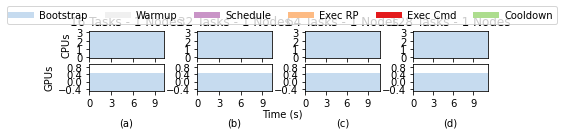

In [12]:
# sessions you want to plot
splot = [os.path.basename(s) for s in sessions]
nsids = len(splot)

# Create figure and 1 subplot for each session
# Use LaTeX document page size (see RA Plotting Chapter)
fwidth, fhight = ra.get_plotsize(516, subplots=(1, nsids))
fig, axarr = plt.subplots(2, nsids, sharex='col', figsize=(fwidth, fhight))

# Avoid overlapping between Y-axes ticks and sub-figures
plt.subplots_adjust(wspace=0.45)

# Generate the subplots with labels

legend = None
for k, rtype in enumerate(rtypes):

    _, consumed, _, _, _ = exp.utilization(metrics=metrics, rtype=rtype)

    j = 'a'
    for i, sid in enumerate(splot):

        # we know we have only 1 pilot
        pid = ss[sid]['p'].list('uid')[0]

        # Plot legend, patched, X and Y axes objects
        legend, patches, x, y = ra.get_plot_utilization(metrics, consumed,
                        p_zeros[sid][pid], sid)

        # Place all the patches, one for each metric, on the axes
        for patch in patches:
            axarr[k][i].add_patch(patch)

        # Title of the plot. Facultative, requires info about session (see RA
        # Info Chapter). We set the title only on the first raw of plots
        if rtype == 'cpu':
            axarr[k][i].set_title('%s Tasks - %s Nodes' % (ss[sid]['ntask'],
                    int(ss[sid]['nnodes'])))

        # Format axes
        axarr[k][i].set_xlim([x['min'],     x['max']])
        axarr[k][i].set_ylim([y['min'], int(y['max'])])
        axarr[k][i].yaxis.set_major_locator(mticker.MaxNLocator(4))
        axarr[k][i].xaxis.set_major_locator(mticker.MaxNLocator(4))

        if rtype == 'cpu':
            # Specific to Summit when using SMT=4 (default)
            axarr[k][i].yaxis.set_major_formatter(
                    mticker.FuncFormatter(lambda z, pos: int(z/4)))

        # Y label per subplot. We keep only the 1st for each raw.
        if i == 0:
            axarr[k][i].set_ylabel('%ss' % rtype.upper())

        # Set x labels to letters for references in the paper.
        # Set them only for the bottom-most subplot
        if rtype == 'gpu':
            axarr[k][i].set_xlabel('(%s)' % j, labelpad=10)

        # update session id and raw identifier letter
        j = chr(ord(j) + 1)
        

# Add legend
fig.legend(legend, [m[0] for m in metrics], 
           loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=6)

# Add axes labels
fig.text( 0.5 , -0.2, 'Time (s)', ha='center')


## Aggregated Resource Utilization

This method is still under development and, as such, it requires to explicitly define the durations for each metric. Defaults will be included in ``rp.utils`` as done with the detailed plotting.

### Metrics

The definition of metrics needs to be accompanied by the explicit definition of the event transitions represented by each metric. RP transitions are documented [here](https://github.com/radical-cybertools/radical.pilot/blob/devel/docs/source/events.md>) but default values will be made available at a later time.

In [13]:
# pick and choose what resources to plot (one sub-plot per resource)
resrc = ['cpu', 'gpu']

# pick and choose what contributions to plot
#            metric     ,  line color,  alpha, fill color,  alpha
metrics  = [['bootstrap', ['#c6dbef' ,  0.0  , '#c6dbef' ,  1  ]],
            ['exec_cmd' , ['#e31a1c' ,  0.0  , '#e31a1c' ,  1  ]],
            ['schedule' , ['#c994c7' ,  0.0  , '#c994c7' ,  1  ]],
            ['exec_rp'  , ['#fdbb84' ,  0.0  , '#fdbb84' ,  1  ]],
            ['term'     , ['#addd8e' ,  0.0  , '#addd8e' ,  1  ]],
            ['idle'     , ['#f0f0f0' ,  0.0  , '#f0f0f0' ,  1  ]] ]

# transition events for pilot, task, master, worker, request
#
# event  : resource transitions from : resource transitions to
#
p_trans = [[{1: 'bootstrap_0_start'}     , 'system'     , 'bootstrap'  ],
           [{5: 'PMGR_ACTIVE'}           , 'bootstrap'  , 'idle'       ],
           [{1: 'cmd', 6: 'cancel_pilot'}, 'idle'       , 'term'       ],
           [{1: 'bootstrap_0_stop'}      , 'term'       , 'system'     ],
           [{1: 'sub_agent_start'}       , 'idle'       , 'agent'      ],
           [{1: 'sub_agent_stop'}        , 'agent'      , 'term'       ] ]

t_trans = [[{1: 'schedule_ok'}           , 'idle'       , 'schedule'   ],
           [{1: 'exec_start'}            , 'schedule'   , 'exec_rp'    ],
           [{1: 'task_exec_start'}       , 'exec_rp'    , 'exec_cmd'   ],
           [{1: 'unschedule_stop'}       , 'exec_cmd'   , 'idle'       ] ]

m_trans = [[{1: 'schedule_ok'}           , 'idle'       , 'schedule'   ],
           [{1: 'exec_start'}            , 'schedule'   , 'exec_rp'    ],
           [{1: 'task_exec_start'}       , 'exec_rp'    , 'exec_master'],
           [{1: 'unschedule_stop'}       , 'exec_master', 'idle'       ] ]

w_trans = [[{1: 'schedule_ok'}           , 'idle'       , 'schedule'   ],
           [{1: 'exec_start'}            , 'schedule'   , 'exec_rp'    ],
           [{1: 'task_exec_start'}       , 'exec_rp'    , 'exec_worker'],
           [{1: 'unschedule_stop'}       , 'exec_worker', 'idle'       ] ]

r_trans = [[{1: 'req_start'}             , 'exec_worker', 'workload'   ],
           [{1: 'req_stop'}              , 'workload'   , 'exec_worker'] ]

# what entity maps to what transition table
tmap = {'pilot'  : p_trans,
        'task'   : t_trans,
        'master' : m_trans,
        'worker' : w_trans,
        'request': r_trans}

### Session

Pick a session to plot and use the ``ra.Session`` object already stored in memory. Also use the ``ra.Entity`` object for the pilot of that session. Here we assume we have a session with a single pilot.

In [15]:
uid = 'rp.session.rivendell.merzky.019270.0003'
session = ss[uid]['s']
pilot   = ss[uid]['p'].get()[0]

### Plotting CPU/GPU Utilization

Stack two plots for the chosen session, one for CPU and one for GPU resources.

Text(0.5, 0.98, '128 Tasks - 1 Nodes')

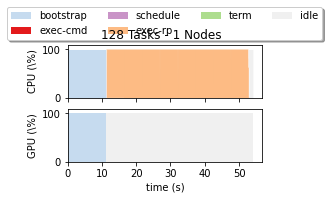

In [16]:
# metrics to stack and to plot
to_stack = [m[0] for m in metrics]
to_plot  = {m[0]: m[1] for m in metrics}

# Use to set Y-axes to % of resource utilization
use_percent = True
    
# Derive pilot and task timeseries of a session for each metric
p_resrc, series, x = ra.get_pilot_series(session, pilot, tmap, resrc, use_percent)

# #plots = # of resource types (e.g., CPU/GPU = 2 resource types = 2 plots)
n_plots = 0
for r in p_resrc:
    if p_resrc[r]:
        n_plots += 1

# sub-plots for each resource type, legend on first, x-axis shared
fig = plt.figure(figsize=(ra.get_plotsize(252)))
gs  = mpl.gridspec.GridSpec(n_plots, 1)

for plot_id, r in enumerate(resrc):

    if not p_resrc[r]:
        continue

    # create sub-plot
    ax = plt.subplot(gs[plot_id])

    # stack timeseries for each metrics into areas
    areas = ra.stack_transitions(series, r, to_stack)

    # plot individual metrics
    prev_m  = None
    lines   = list()
    patches = list()
    legend  = list()
    for num, m in enumerate(areas.keys()):

        if m not in to_plot:
            if m != 'time':
                print('skip', m)
            continue

        lcol   = to_plot[m][0]
        lalpha = to_plot[m][1]
        pcol   = to_plot[m][2]
        palpha = to_plot[m][3]

        # plot the (stacked) areas
        line, = ax.step(areas['time'], areas[m], where='post', label=m,
                        color=lcol, alpha=lalpha, linewidth=1.0)

        # fill first metric toward 0, all others towards previous line
        if not prev_m:
            patch = ax.fill_between(areas['time'], areas[m],
                                    step='post', label=m, linewidth=0.0,
                                    color=pcol, alpha=palpha)

        else:
            patch = ax.fill_between(areas['time'], areas[m], areas[prev_m], 
                                    step='post', label=m, linewidth=0.0,
                                    color=pcol, alpha=palpha)

        # remember lines and patches for legend
        legend.append(m.replace('_', '-'))
        patches.append(patch)

        # remember this line to fill against
        prev_m = m

    ax.set_xlim([x['min'], x['max']])
    if use_percent:
        ax.set_ylim([0, 110])
    else:
        ax.set_ylim([0, p_resrc[r]])

    ax.set_xlabel('time (s)')
    ax.set_ylabel('%s (%s)' % (r.upper(), '\%'))


    # first sub-plot gets legend
    if plot_id == 0:
        ax.legend(patches, legend, loc='upper center', ncol=4,
                  bbox_to_anchor=(0.5, 1.8), fancybox=True, shadow=True)

for ax in fig.get_axes():
    ax.label_outer()

# Title of the plot
fig.suptitle('%s Tasks - %s Nodes' % (ss[uid]['ntask'], ss[uid]['nnodes']))